## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import arcpy
import gdal
import rasterio
import geopandas as gpd
import arcgis
from arcpy import env
import shapely 
from fiona.crs import from_epsg
from pysheds.grid import Grid

In [3]:
from arcpy.sa import *
arcpy.CheckOutExtension("Spatial")

'CheckedOut'

In [5]:
import gdown
import requests
import json
from bs4 import BeautifulSoup
from io import BytesIO
from zipfile import ZipFile
import warnings

## Obtaining linked dataframe

In [5]:
#Indexando metadata y vinculos de cada cuenca:
index = []
max_iter = 200
for number in range(1,max_iter):
    url = "http://cartocdn-gusc-c.global.ssl.fastly.net/geogpsperu/api/v1/map/geogpsperu@c0c208f3@e3b428f0fea75bcaff1b4d6e3b827307:1591749805234/4/attributes/{}?".format(
           number)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    dictionary=json.loads(str(soup))
    index.append(dictionary)

In [6]:
df=pd.DataFrame(index)
df = df[["nombre","rios_lagos","lim_cuenca","curvas"]].dropna()
df.to_csv("watershed_metadata.csv",index = False)

## Choose a watershed of interest

In [7]:
df = pd.read_csv('watershed_metadata.csv')
df.head()

,nombre,rios_lagos,lim_cuenca,curvas
0,Cuenca Tumbes,https://drive.google.com/drive/folders/1focr2s...,https://drive.google.com/drive/folders/1lNLoZy...,https://drive.google.com/file/d/1gIgwKeAH8QkO8...
1,Cuenca Tarau,https://drive.google.com/drive/folders/1AmRVkG...,https://drive.google.com/drive/folders/1Hy84_N...,https://drive.google.com/file/d/1kMKs0HYiw3KIz...
2,Cuenca Ilpa,https://drive.google.com/drive/folders/1oN32DU...,https://drive.google.com/drive/folders/1R4BHB2...,https://drive.google.com/file/d/1Gi4qY0igKXwOk...
3,Cuenca Callaccame,https://drive.google.com/drive/folders/1VFsOGu...,https://drive.google.com/drive/folders/1Aw6epj...,https://drive.google.com/file/d/1jYBe1PSZoaK0E...
4,Cuenca Ilave,https://drive.google.com/drive/folders/1zB1F0u...,https://drive.google.com/drive/folders/19a_sx2...,https://drive.google.com/file/d/1H4DCF6MGflxeX...


In [8]:
print("Digite el nombre de la cuenca de interés")
cuenca = input()
print(('Buscando: {}').format(cuenca))
numbers = []
for i in range(1,len(df)):
    if list(df.loc[i])[0] == str(cuenca):  
        numbers.append(i)
print("Búsqueda realizada")   

Digite el nombre de la cuenca de interés
Cuenca Urubamba
Buscando: Cuenca Urubamba
Búsqueda realizada


## Obtain download link 

In [9]:
link = "https://drive.google.com/uc?id={}&export=download".format(df.loc[numbers[0]][3][32:65])
print(link)

https://drive.google.com/uc?id=17R3_u18D2JapLiRsilk65zT40-gdLT2w&export=download


## Extracting level curve files of the watershed of interest

### Set our workspace and outworkspace

In [10]:
workspace = r"C:\Users\jf_ph\OneDrive\Escritorio\Esri Training\Watershed\Inputs" # you can define your workspace 
outworkspace = r"C:\Users\jf_ph\OneDrive\Escritorio\Esri Training\Watershed\Outcomes" # you can define your outworkspace

### Extracting level curves files from downloaded zipped files

In [11]:
def extr_level_curves(link):
    gdown.extractall(gdown.download(link,"Level_curves.zip", quiet=False),workspace)
    print("Descargado correctamente en {}".format(workspace))   

In [12]:
extr_level_curves(link)

Downloading...
From: https://drive.google.com/uc?id=17R3_u18D2JapLiRsilk65zT40-gdLT2w&export=download
To: C:\Users\jf_ph\OneDrive\Documentos\Python Scripts\Level_curves.zip
70.7MB [00:35, 1.97MB/s]


Descargado correctamente en C:\Users\jf_ph\OneDrive\Escritorio\Esri Training\Watershed\Inputs


## Level Curves to DEM

In [13]:
for zf_element in os.listdir(workspace):
    if ".shp" in zf_element:
        if ".xml" in zf_element:
            pass
        else:
            inFeatures = os.path.join(workspace,zf_element)        
inFeatures

'C:\\Users\\jf_ph\\OneDrive\\Escritorio\\Esri Training\\Watershed\\Inputs\\Cuenca_Urubamba_Curvas_de_Nivel_geogspperu_juansuyo_931381206.shp'

In [14]:
outTTR = TopoToRaster(TopoContour([[inFeatures,"alt_hip"]]))
outTTR.save(os.path.join(outworkspace,"DEM"))

## Fill the DEM

In [15]:
outFill = Fill(os.path.join(outworkspace,"DEM"))
outFill.save(os.path.join(outworkspace,"FillDEM"))

In [16]:
#Obtaining right raster extent
def raster_extent(data):
    new_list = []
    lista =list(data.bounds)
    for i in (0,2,1,3):
        new_list.append(lista[i])
    return new_list    

In [17]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data.read(1),extent = raster_extent(data), cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

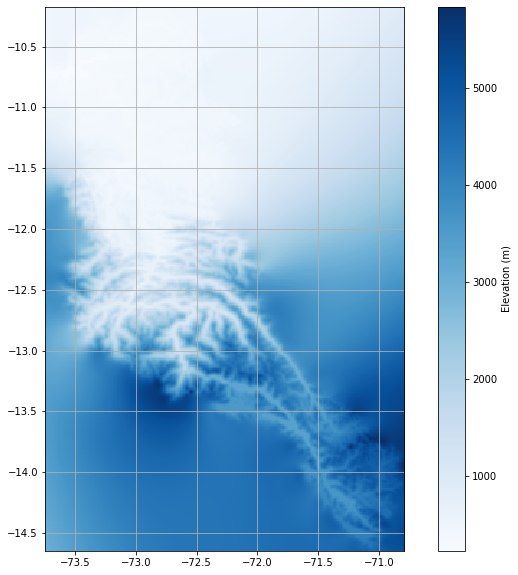

In [18]:
dataset = rasterio.open(os.path.join(outworkspace,"FillDEM"))
plotFigure(dataset,"Elevation (m)")

## Cliping with watershed feature

In [19]:
desc =arcpy.Describe(os.path.join(outworkspace,"FillDEM"))
boundaries = str(desc.extent.XMin-0.005)+" "+str(desc.extent.YMin-0.005)+" "+str(desc.extent.XMax+0.005)+" "+str(desc.extent.YMax+0.005)

In [20]:
#Download peruvian watershed features
response = requests.get("https://drive.google.com/uc?id=13tHdH7PdG9QT36JNbWaydr-iFCNTvy1f&export=download")
with ZipFile(BytesIO(response.content)) as zp:
    FileNames = zp.namelist()
    for uh in FileNames:
        zp.extract(uh,workspace)
uh_file = os.path.join(workspace,FileNames[4])     
env.outputCoordinateSystem = arcpy.SpatialReference("WGS 1984")
where_clause =""""NOMBRE" = '{}'""".format(str(cuenca))
outcome= "Spec_Watershed"
arcpy.FeatureClassToFeatureClass_conversion(uh_file,outworkspace,outcome, where_clause)

<Result 'C:\\Users\\jf_ph\\OneDrive\\Escritorio\\Esri Training\\Watershed\\Outcomes\\Spec_Watershed.shp'>

In [21]:
to_clipped = os.path.join(outworkspace,"FillDEM")
out_clipped = os.path.join(outworkspace,"c_FillDEM.tif")
in_template_dataset = os.path.join(outworkspace,"Spec_Watershed.shp")
clipping_geometry= "ClippingGeometry"
arcpy.Clip_management(to_clipped, boundaries, out_clipped, in_template_dataset,"0",
                          clipping_geometry,"NO_MAINTAIN_EXTENT")

<Result 'C:\\Users\\jf_ph\\OneDrive\\Escritorio\\Esri Training\\Watershed\\Outcomes\\c_FillDEM.tif'>

###  Visualizing with Rasterio and Matplotlib

In [22]:
#Plot with noData value = 0
def plotFigureNan(data, label, cmap='Blues'):
    x = data.read(1).astype(float)
    x[x == 0] = np.nan
    plt.figure(figsize=(12,10))
    plt.imshow(x,extent = raster_extent(data), cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

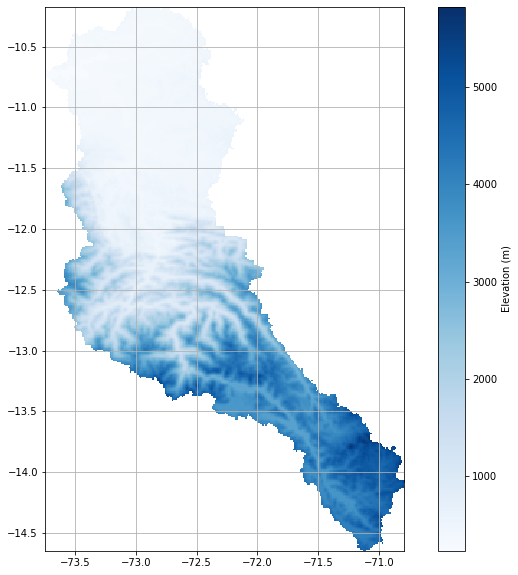

In [23]:
ds = rasterio.open(os.path.join(outworkspace,"c_FillDEM.tif"))
plotFigureNan(ds,"Elevation (m)")

## Flow Direction of DEM

In [24]:
outFlowDirection = FlowDirection(os.path.join(outworkspace,"c_FillDEM.tif"), "NORMAL")
outFlowDirection.save(os.path.join(outworkspace,"FlowDirDEM.tif"))

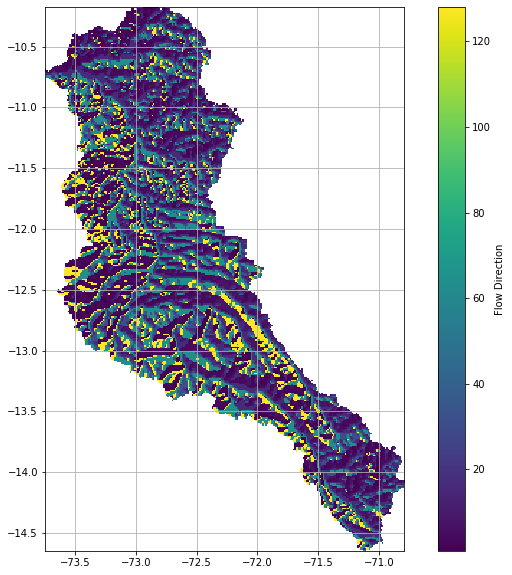

In [25]:
flow_dir = rasterio.open(os.path.join(outworkspace,"FlowDirDEM.tif"))
plotFigureNan(flow_dir,"Flow Direction","viridis")

## Watershed delimitation

### Flow Accumulation of DEM

In [27]:
#Plot without outline values > e+38
def plotFigureE(data, label, cmap='Blues'):
    x = data.read(1).astype(float)
    x[x >1e+30] = np.nan
    plt.figure(figsize=(12,10))
    plt.imshow(x,extent = raster_extent(data), cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

In [28]:
outFlowAccumulation = FlowAccumulation(os.path.join(outworkspace,"FlowDirDEM.tif"))
outFlowAccumulation.save(os.path.join(outworkspace,"FlowAccDEM.tif"))

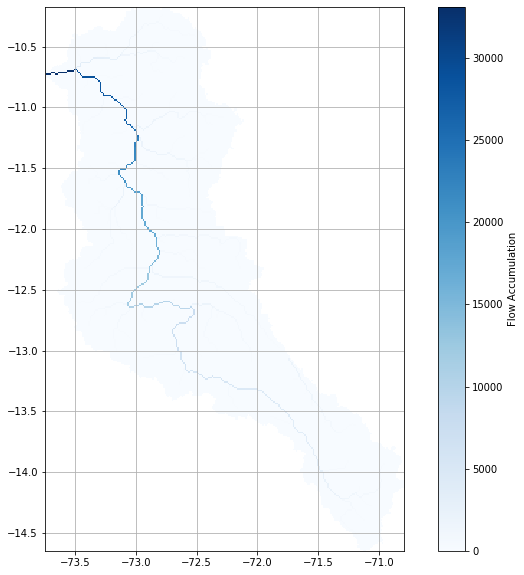

In [30]:
data_fd = rasterio.open(os.path.join(outworkspace,"FlowAccDEM.tif"))
plotFigureE(data_fd,"Flow Accumulation","Blues")

### Stream Link

In [83]:
outStreamLink = StreamLink(os.path.join(outworkspace,"FlowAccDEM.tif"), os.path.join(outworkspace,"FlowDirDEM.tif"))
outStreamLink.save(os.path.join(outworkspace,"StreamLink"))

### Stream to Feature

In [84]:
StreamToFeature(os.path.join(outworkspace,"StreamLink"),os.path.join(outworkspace,"FlowDirDEM.tif"),os.path.join(outworkspace,"StreamFeat"),"NO_SIMPLIFY")

<geoprocessing server result object at 0x2567661df80>

In [106]:
str_feat = gpd.read_file(os.path.join(outworkspace,"StreamFeat.shp"))

In [142]:
#Plotting feature and raster
def plot_def_fr(geodata,data,label):
    x = data.read(1).astype(float)
    try:
        if x[x == 0]:
            x[x == 0] = np.nan
        else:
            x = data.read(1)
    except:
        pass
    fig = plt.figure(figsize =(12,10))
    ax = fig.add_subplot(1,1,1)
    geodata.plot(ax = ax)
    img = ax.imshow(x,extent =raster_extent(data), cmap="viridis")
    fig.colorbar(img, label = label)
    plt.grid()

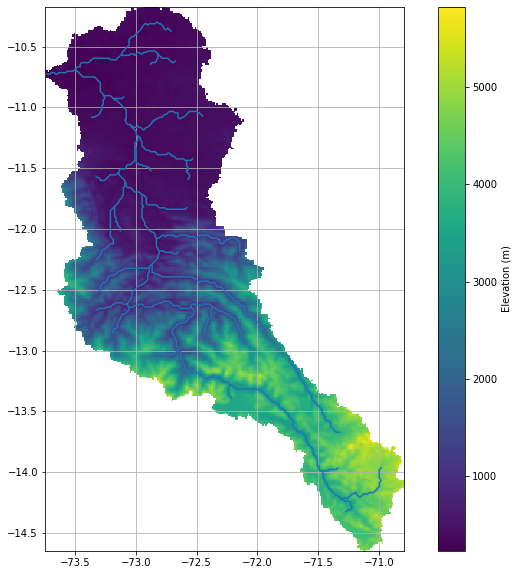

In [123]:
plot_def_fr(str_feat,ds,"Elevation (m)")

## Delimitation micro watershed with discharge point

In [32]:
print("Digite las cooordenadas longitud y latitud del punto de desfogue (separadas por coma)")
try:
    point = input()
    print(('Obteniendo: {}').format(point))
    point = str(point).split(",")   
    print("Coordenadas obtenidas")
except Exception as e:
    print(e)

Digite las cooordenadas longitud y latitud del punto de desfogue (separadas por coma)
-72.983276, -11.245486
Obteniendo: -72.983276, -11.245486
Coordenadas obtenidas


In [33]:
lon= float(point[0])
lat = float(point[1])

In [34]:
#Plotting two features
def plot_def(lon,lan,data,label):
    x = data_fd.read(1).astype(float)
    x[x >1e+30] = np.nan
    fig = plt.figure(figsize =(12,10))
    ax = fig.add_subplot(1,1,1)
    ax.scatter(lon,lat,s=20,c="red")
    img = ax.imshow(x,extent =raster_extent(data), cmap="Blues")
    fig.colorbar(img)
    plt.grid()

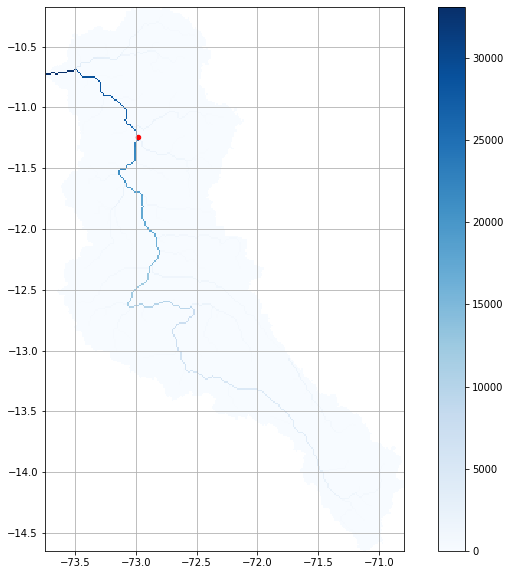

In [35]:
plot_def(lon,lat,data_fd,"Flow Accumulation")

### Creating a geodataframe

In [36]:
newdata = gpd.GeoDataFrame()
newdata['type'] = None
newdata['geometry'] = None

In [37]:
newdata.loc[0,'type'] = shapely.geometry.Point(lon,lat)
newdata.loc[0,'type'] = "Point"
newdata

,type,geometry
0,Point,POINT (-72.98328 -11.24549)


### Importing geodataframe to shapefile

In [38]:
newdata.crs = from_epsg(4326)
newdata.to_file(os.path.join(outworkspace,"Desfogue.shp"))

C:\Users\jf_ph\AppData\Local\ESRI\conda\envs\arcgispro-py3-clone7\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Watershed tool

In [39]:
outWatershed = Watershed(os.path.join(outworkspace,"FlowDirDEM.tif"),os.path.join(outworkspace,"Desfogue.shp"))
outWatershed.save(os.path.join(outworkspace,"Watersheds.tif"))

In [44]:
watershed = rasterio.open(os.path.join(outworkspace,"Watersheds.tif"))
plotFigure(watershed,"Flow Accumulation","Blues")

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

## Visualizing with pysheds

In [58]:
def plotFigureGrid(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()

In [ ]:
grid_dem = Grid.from_raster(os.path.join(outworkspace,"c_FillDEM.tif"),data_name="dem")
grid_dem.read_raster(os.path.join(outworkspace,"Watersheds.tif"), data_name="Watersheds.tif")
grid_dem.clip_to("Watersheds.tif")

In [126]:
grid = Grid.from_raster(os.path.join(outworkspace,"FlowAccDEM.tif"),data_name="flow")
grid.read_raster(os.path.join(outworkspace,"Watersheds.tif"), data_name="Watersheds.tif")
grid.clip_to("Watersheds.tif")
grid.view("Watersheds.tif")

Raster([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

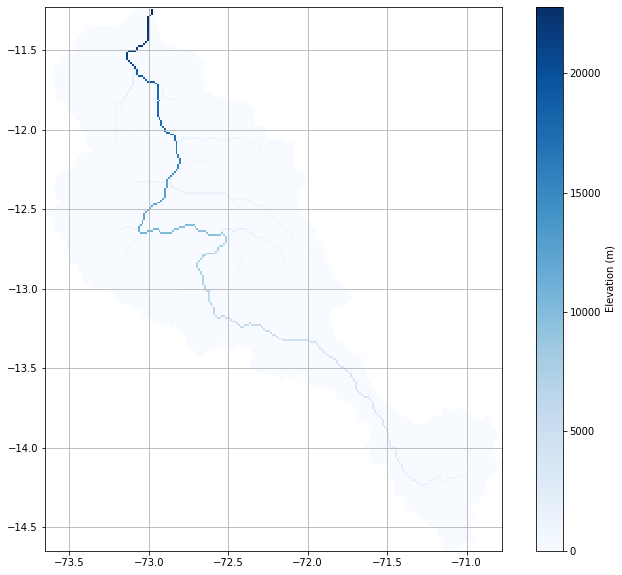

In [129]:
flowView = grid.view('flow', nodata=np.nan)
demView = grid_dem.view('dem', nodata=np.nan)
plotFigureGrid(flowView,'Elevation (m)')

In [130]:
grid.to_raster(flowView,os.path.join(outworkspace,"Microwatershed.tif"))
grid_dem.to_raster(demView,os.path.join(outworkspace,"Microwatershed_dem.tif"))

## Extracting river network of microwatershed

In [112]:
flowacc=os.path.join(outworkspace,"Microwatershed.tif")
outStreamLink = StreamLink(flowacc, os.path.join(outworkspace,"FlowDirDEM.tif"))
outStreamLink.save(os.path.join(outworkspace,"StreamLink_Micro.tif"))

In [114]:
StreamToFeature(os.path.join(outworkspace,"StreamLink_Micro.tif"),os.path.join(outworkspace,"FlowDirDEM.tif"),os.path.join(outworkspace,"StreamFeat_Micro"),"NO_SIMPLIFY")

<geoprocessing server result object at 0x2567e6b6b48>

In [131]:
str_micr = gpd.read_file(os.path.join(outworkspace,"StreamFeat_Micro.shp"))
d_m = rasterio.open(os.path.join(outworkspace,"Microwatershed_dem.tif"))

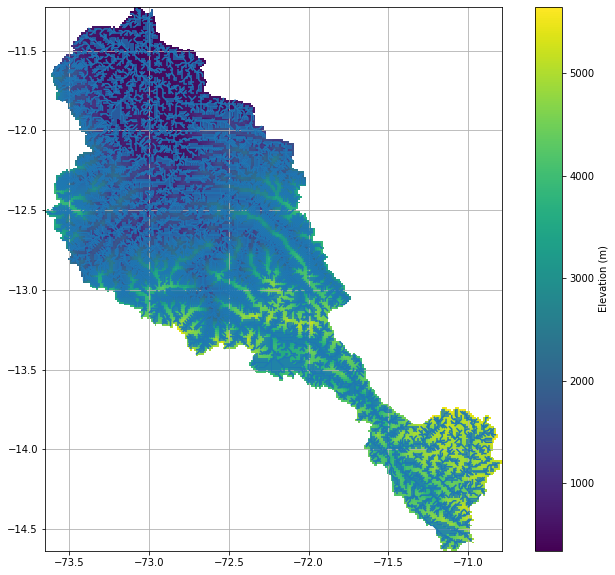

In [146]:
plot_def_fr(str_micr,d_m,"Elevation (m)")
warnings.filterwarnings("ignore")